<a href="https://colab.research.google.com/github/fabrytp8/AG1/blob/main/clf/Programa16_Clasificacion_CART.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn import tree
from sklearn import datasets
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from evaluacion_funciones import *

In [ ]:
seed=42

In [ ]:
# Cargamos el conjunto de datos
datos_iris = datasets.load_iris()
datos_wine = datasets.load_wine()
datos_breast = datasets.load_breast_cancer()

X = {
    'IRIS': datos_iris.data,
    'WINE': datos_wine.data,
    'BREAST': datos_breast.data
}

y = {
    'IRIS': datos_iris.target,
    'WINE': datos_wine.target,
    'BREAST': datos_breast.target
}

In [ ]:
# Métricas de evaluación.
metricas = {
  'ACC':    metrics.accuracy_score,
  'PREC':   lambda y_true, y_pred:
            metrics.precision_score(y_true, y_pred, average='micro'),
  'RECALL': lambda y_true, y_pred:
            metrics.recall_score(y_true, y_pred, average='micro'),
  'F1':     lambda y_true, y_pred:
            metrics.f1_score(y_true, y_pred, average='micro')
}

In [ ]:
# 1) Partición externa
# 2) Extracción de características (en caso de trabajar con imágenes)

# 3) Estandarizacion de los datos
standardizer = preprocessing.StandardScaler()
for nombre, exp in X.items():
    X[nombre] = standardizer.fit_transform(X[nombre])

# 4) Selección de atributos

In [ ]:
# 5) Construcción del algoritmo de aprendizaje.
algoritmos = {'DT': tree.DecisionTreeClassifier(random_state=seed)}

In [ ]:
# 5.1) Validación cruzada interna y Optimización de los hiperparámetros
y_pred = {}
for nombre, exp in X.items():
    y_pred[nombre] = cross_val_predict(algoritmos['DT'], X[nombre], y[nombre], 
                                       cv=KFold(n_splits=10, shuffle=True, random_state=seed))

In [ ]:
# Mostramos el resultado de varias métricas
results={}
for nombre, exp in X.items():
    results[nombre] = evaluacion(y[nombre], y_pred[nombre], metricas)
    print("Matriz de confusión (%s):\n%s" % (nombre, metrics.confusion_matrix(y[nombre], y_pred[nombre])))
    print("Tabla de métricas (%s):\n%s" % (nombre, metrics.classification_report(y[nombre], y_pred[nombre], digits=3)))

Matriz de confusión (IRIS):
[[50  0  0]
 [ 0 46  4]
 [ 0  5 45]]
Tabla de métricas (IRIS):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        50
           1      0.902     0.920     0.911        50
           2      0.918     0.900     0.909        50

    accuracy                          0.940       150
   macro avg      0.940     0.940     0.940       150
weighted avg      0.940     0.940     0.940       150

Matriz de confusión (WINE):
[[54  5  0]
 [ 6 61  4]
 [ 1  2 45]]
Tabla de métricas (WINE):
              precision    recall  f1-score   support

           0      0.885     0.915     0.900        59
           1      0.897     0.859     0.878        71
           2      0.918     0.938     0.928        48

    accuracy                          0.899       178
   macro avg      0.900     0.904     0.902       178
weighted avg      0.899     0.899     0.899       178

Matriz de confusión (BREAST):
[[194  18]
 [ 19 338]]
Tab

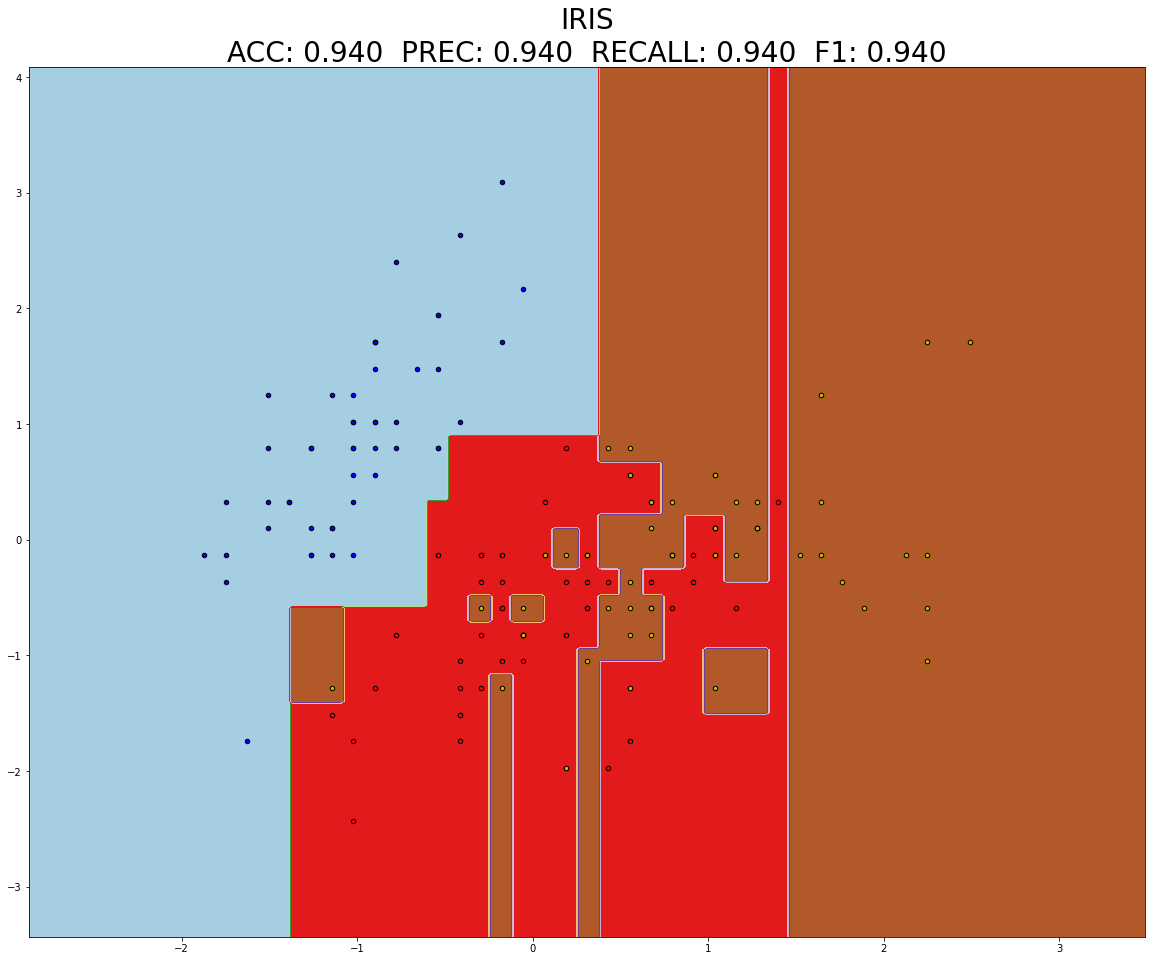

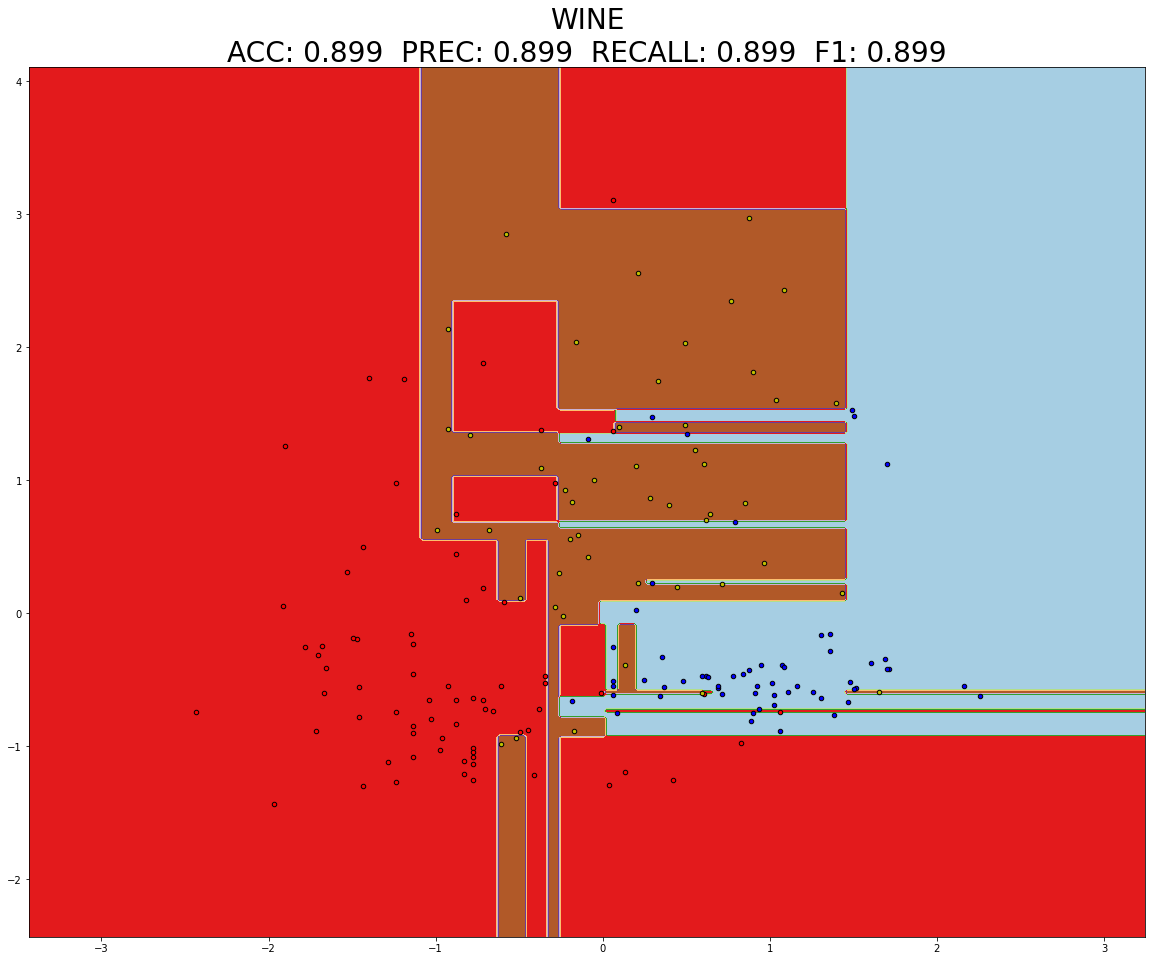

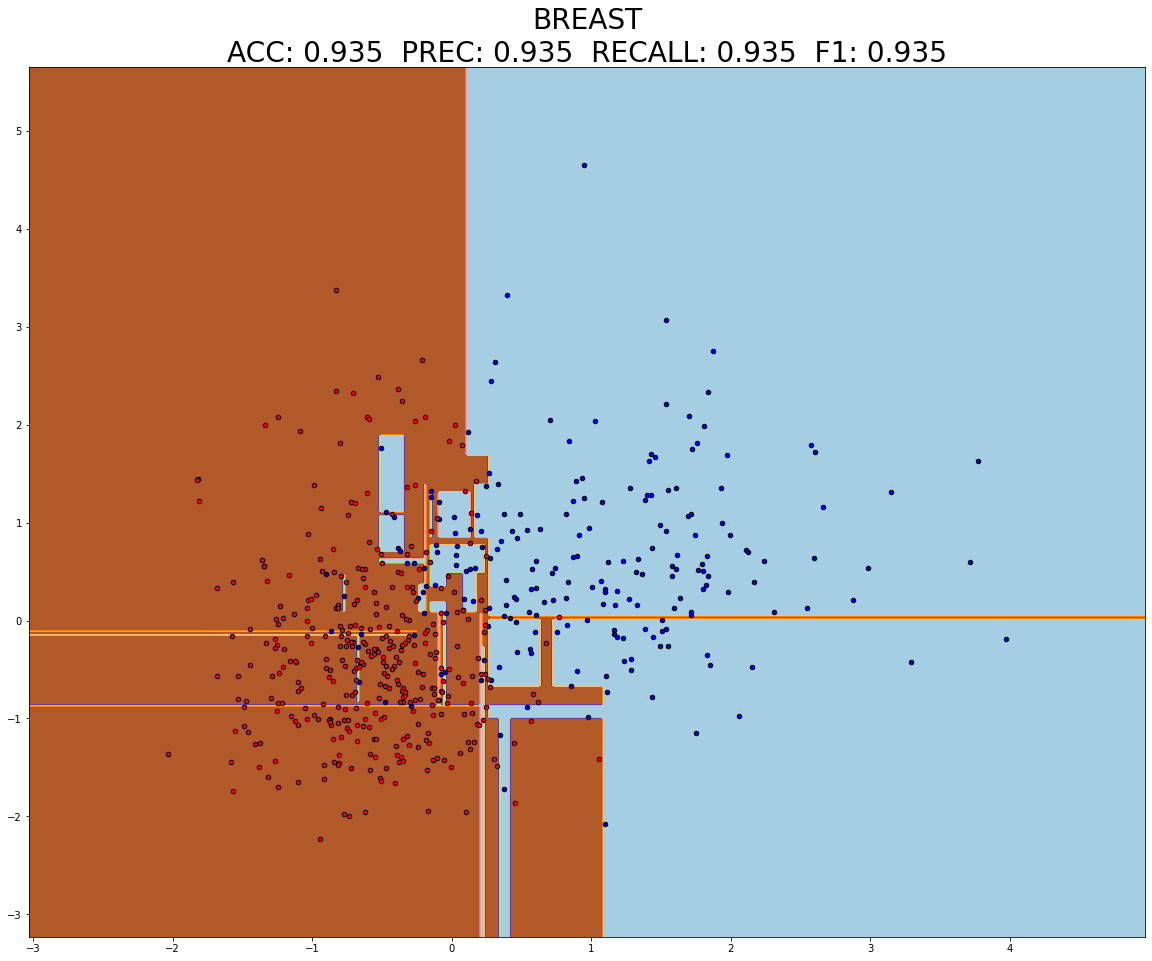

In [ ]:
# 5.2) Entrenamiento del modelo definitivo (usamos 2 atributos para poder obtener gráficos en 2D)
for nombre, exp in X.items():
    modelo_definitivo = algoritmos['DT'].fit(X[nombre][:,:2], y[nombre])
    mapa_modelo_clasif_2d(X[nombre][:,:2], y[nombre], modelo_definitivo, results[nombre], nombre)

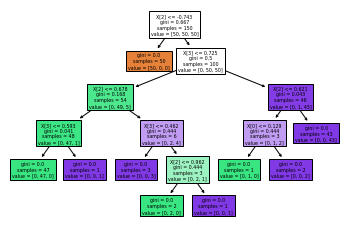

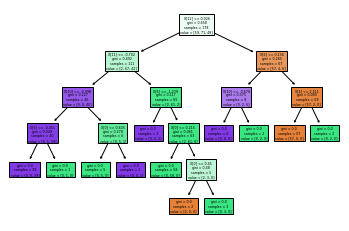

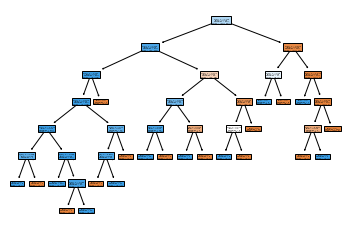

In [ ]:
# 5.3) Ploteamos el árbol con todos los datos para visualización árbol.
for nombre, exp in X.items():
    modelo_completo = algoritmos['DT'].fit(X[nombre], y[nombre])
    plt.figure()
    tree.plot_tree(modelo_completo,filled=True)  
    plt.savefig('tree_' + nombre + '.pdf',format='pdf',bbox_inches = "tight")

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree
import graphviz


# Calculo de las metricas de evaluacion.
def evaluacion(y_true, y_pred, metricas):
    res = {}
    for nombre, funcion in metricas.items():
        res[nombre] = funcion(y_true, y_pred)
    return res

# Grafica de realidad -vs- prediccion.
def grafica_real_vs_pred(y_true, y_pred, metricas, algoritmo):
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    ax.set_xlabel('Valor real de la clase')
    ax.set_ylabel('Predicción')
    plt.title("%s\nMAE: %.3f  RMSE: %.3f  MAPE: %.3f  R2: %.3f" %
              (algoritmo,metricas['MAE'],metricas['RMSE'],metricas['MAPE'],metricas['R2']))
    plt.show()

# Grafica con mapa de regiones de clasificacion segun modelo ya entrenado que admita coef_ e intercept_.
def mapa_modelo_clasif_2d(X, y, modelo, metricas, algoritmo):
    # create a mesh to plot in
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = modelo.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(20,16))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title("%s\nACC: %.3f  PREC: %.3f  RECALL: %.3f  F1: %.3f" %
              (algoritmo,metricas['ACC'],metricas['PREC'],metricas['RECALL'],metricas['F1']), fontsize=28)
    plt.axis('tight')

    # Plot also the training points
    colors = "bry"
    for i, color in zip(modelo.classes_, colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired,
                    edgecolor='black', s=20)

    # Plot the three one-against-all classifiers
    if (hasattr(modelo, 'coef_')):
        xmin, xmax = plt.xlim()
        ymin, ymax = plt.ylim()
        coef = modelo.coef_
        intercept = modelo.intercept_

        def plot_hyperplane(c, color):
            def line(x0):
                return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]

            plt.plot([xmin, xmax], [line(xmin), line(xmax)],
                     ls="--", color=color)

        for i, color in zip(modelo.classes_, colors):
            plot_hyperplane(i, color)

    plt.show()

# Visualizacion de modelo de tipo arbol.
def mostrar_modelo_arbol(modelo, datos, nombre_archivo = "modelo"):
    dot_data = tree.export_graphviz(modelo, out_file=None, feature_names=datos.feature_names,
                         class_names=datos.target_names, filled=True,
                         rounded=True, special_characters=True)

    graph = graphviz.Source(dot_data)
    graph.render(nombre_archivo, view=True)